In [30]:
import pickle
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from math import log
from collections import Counter
import ast

In [31]:
tweets = pd.read_csv("data/tokenized_tweets.csv")
tweets['Date'] = pd.to_datetime(tweets['Date'])
vectorizer_fp = 'classifiers/tfidfvectorizersarik.pkl'
classifier_fp = 'classifiers/ordinallogistic.pkl'

with open(classifier_fp, 'rb') as f:
    classifier = pickle.load(f)

with open(vectorizer_fp, 'rb') as f:
    vectorizer = pickle.load(f)

In [32]:
def classify_tweets(classifier, vectorizer, tweets):
    X_tokens = vectorizer.transform(tweets['Tokens'])
    predictions = classifier.predict(X_tokens)
    tweets['Predictions'] = predictions
    return tweets

In [33]:
tweets = classify_tweets(classifier, vectorizer, tweets)
tweets['Tokens'] = tweets['Tokens'].apply(ast.literal_eval)

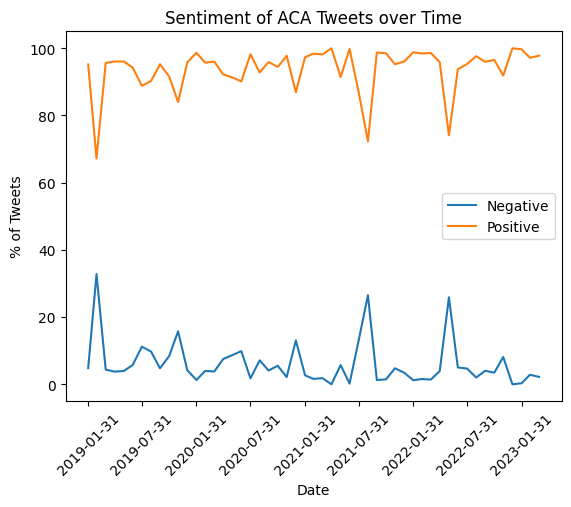

In [34]:
max_prediction = tweets['Predictions'].max()
min_prediction = tweets['Predictions'].min()

grouped_data = tweets.groupby(pd.Grouper(key='Date', freq='M')).agg(
    {'Predictions': ['min', 'max', 'size', lambda x: (
    x == min_prediction).sum(), lambda x: (x == max_prediction).sum()]})
grouped_data.columns = ['Min Prediction', 'Max Prediction', 'Total', 'Min Count', 'Max Count']

grouped_data['Min Frequency'] = grouped_data['Min Count'] / grouped_data['Total'] * 100
grouped_data['Max Frequency'] = grouped_data['Max Count'] / grouped_data['Total'] * 100

plt.plot(grouped_data.index, grouped_data['Min Frequency'], label='Negative')
plt.plot(grouped_data.index, grouped_data['Max Frequency'], label='Positive')

plt.xlabel('Date')
plt.ylabel('% of Tweets')
plt.title('Sentiment of ACA Tweets over Time')
plt.legend()

plt.xticks(rotation=45)
plt.gca().set_xticks(grouped_data.index[::6])

plt.show()

In [39]:
max_token_counts = {}
min_token_counts = {}
all_tokens = set()

max_tweets = tweets[tweets['Predictions'] == max_prediction]
min_tweets = tweets[tweets['Predictions'] == min_prediction]

total_max_tweets = len(max_tweets)
total_min_tweets = len(min_tweets)

for index, row in max_tweets.iterrows():
    tokens = row['Tokens']
    
    for token in tokens:
        max_token_counts[token] = max_token_counts.get(token, 0) + 1
        all_tokens.add(token)

for index, row in min_tweets.iterrows():
    tokens = row['Tokens']
    
    for token in tokens:
        min_token_counts[token] = min_token_counts.get(token, 0) + 1
        all_tokens.add(token)

# Now we can create a homemade metric that indicates which tokens are most
# associated with positive and negative sentiment. We'll just take difference
# in how often a token appears in each dictionary. This helps target the most
# common tokens while still capturing the differences between the dictionaries.

frequency_scores = {}

for token in all_tokens:
    min_frequency = min_token_counts.get(token, 0) / total_min_tweets
    max_frequency = max_token_counts.get(token, 0) / total_max_tweets
    frequency_score = max_frequency - min_frequency
    frequency_scores[token] = frequency_score

sorted_scores = sorted(frequency_scores.items(), key=lambda x: x[1], reverse=True)

print("Top tokens associated with positive sentiment:")
for token, score in sorted_scores[:10]:
    if score > 0:
        print(f"Token: {token}\tFrequency Score: {score}")

print("Top tokens associated with negative sentiment:")
for token, score in sorted_scores[-10:]:
    if score < 0:
        print(f"Token: {token}\tFrequency Score: {score}")


Top tokens associated with positive sentiment:
Token: rt	Frequency Score: 0.3282788372999008
Token: care	Frequency Score: 0.2121483373900501
Token: must	Frequency Score: 0.10677419380803359
Token: al	Frequency Score: 0.1041507295650942
Token: coronavirus	Frequency Score: 0.10348187436412574
Token: middle	Frequency Score: 0.10260704419889503
Token: crisis	Frequency Score: 0.09742790876250822
Token: woman	Frequency Score: 0.09701581797576274
Token: read	Frequency Score: 0.09441318062692372
Token: @speakerpelosi	Frequency Score: 0.09379942111295703
Top tokens associated with negative sentiment:
Token: aca	Frequency Score: -0.1083006944712746
Token: said	Frequency Score: -0.11845707526819405
Token: dont	Frequency Score: -0.12812717324112352
Token: would	Frequency Score: -0.12847098803590515
Token: people	Frequency Score: -0.12939517894628394
Token: obamacareaca	Frequency Score: -0.1570564938054579
Token: lie	Frequency Score: -0.15895723463920977
Token: history	Frequency Score: -0.175856860